In [124]:
import numpy as np
#import pandas as pd
import geopandas as gpd
#import contextily as cx
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from shapely.geometry import Point, LineString
#from shapely.geometry import asPoint
from numpy import asarray
import syslog
import paho.mqtt.client as mqtt #import library
from queue import Queue
import sys
import os
#import datetime 
import math
import json
import signal
import pdb
from pathlib import Path
from argparse import ArgumentParser

from django.utils.dateparse import parse_datetime
from django.contrib.gis.geos import Point, LineString
from django.conf import settings
from django.utils import timezone

# set the datetime epoch as not starting at the typical unix epoch but the otle epoch:
epoch = datetime.strptime('Q2020-01-01T00:00:00.000Z', "Q%Y-%m-%dT%H:%M:%S.%f%z")


Text(0, 0.5, 'T')

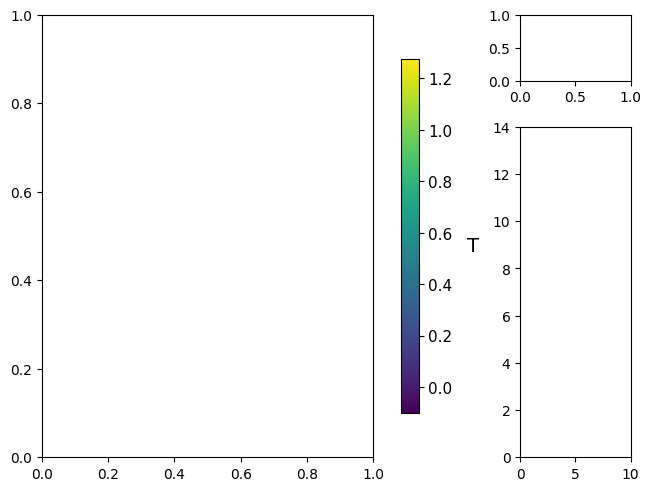

In [149]:
cur_data = {}
utm = None

# set up the plot
#fig, ax = plt.subplots(1, figsize = (8,8))
fig, axs = plt.subplot_mosaic([['boats',    'time'], ['boats',   'words']], width_ratios= [3,1],height_ratios= [1,5],constrained_layout=False)

boats_ax = axs['boats']
time_ax = axs['time']
words_ax = axs['words']
words_ax.axis([0, 10, 0, 14])  # 12 boats - 14 lines

# create the norm object for the colormap
norm = plt.Normalize(255/200, 0/200) # the complete range of linear values

# Create the colorbar
smap = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar = fig.colorbar(smap, ax=boats_ax, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=11)
cbar.ax.set_ylabel('T', rotation=0, labelpad = 15, fontdict = {"size":14})


In [122]:
def lonlat2UTM(lonlat):  # lonlat is [long, lat]
    utm = (np.floor((lonlat[0] + 180) / 6) % 60) + 1
    if(lonlat[1] > 0): 
        utm = utm + 32600
    else:
        utm = utm + 32700
    return int(utm)



In [82]:
fname = "/home/vagrant/otle/otle/pi_code/mqtt_data/server_2022_279_201414"

In [83]:
mqtt_file =  open(fname, "rb")


In [33]:
pl = mqtt_file.read(24)
pl

b'otle\x00\x03\t\xdc\xc0\xb6\x0c\xefr\xd2z\x10\x03\x004\x0e9\x8e\x94\x81'

In [147]:
pl = mqtt_file.read(24)
if (pl[0:4] == b'otle'):
    mqtt_msg_index = int.from_bytes(pl[4:6], byteorder='big', signed = True)
    llat = int.from_bytes(pl[6:11], byteorder='big', signed = True)* 1e-9
    llong = int.from_bytes(pl[11:16], byteorder='big', signed = True)* 1e-9
    err_2d = int.from_bytes(pl[16:17], byteorder='big', signed = False)/200
    meas_time = epoch + timedelta(seconds = (int.from_bytes(pl[17:22], byteorder='big', signed = False)/10))
    course_t = int.from_bytes(pl[22:23], byteorder='big', signed = False)*360/256
    boat_id = int.from_bytes(pl[23:24], byteorder='big', signed = False)

    boat_id

    if (utm is None):
        utm = lonlat2UTM([llong, llat])
    print(utm)
    
    tmp_point = Point(llong, llat, srid=4326)
    trans_point = tmp_point.transform(utm, clone=True)
        
    # the dictionary to hold the most recent boat_id: [long, lat, easting, northing, course_t, err_2d,  time] data
    cur_data[str(boat_id)]=[llong, llat, trans_point[0], trans_point[1], course_t, err_2d, meas_time]
    #print(cur_data)


cur_data.keys()

32619


dict_keys(['129', '130', '2', '128'])

In [153]:
cur_data.keys()

dict_keys([])

In [151]:
    # make arrays
    #rc = np.array(cur_data['129'])
    #pi = np.array(cur_data['130'])
    # set rc and pin so normal start will be to positive y/north (rc boat on right end of line)
    if ('129' in cur_data.keys() and '130' in cur_data.keys()):
        line = np.array([cur_data['129'][2:4],cur_data['130'][2:4]])
        l_tmp = np.array(cur_data['129']) - np.array(cur_data['130'])
    else:
        print("129: " + str('129' in cur_data.keys()) + "   130: " + str('130' in cur_data.keys()))

    # compute the line rotation 
    line_angle = (-np.arctan2(l_tmp[0], l_tmp[1]) + np.pi/2)   # clockwise from north
    # compute the line rotation matrice
    line_R = rotation(line_angle)

    # rotate the line
    r_line = np.matmul(line,line_R)

    # get the translation vector
    rc_trans = np.array(r_line[0,:])
    rc_trans[0] -= (r_line[0,0]-r_line[1,0])/2

    # translate the line
    rt_line = r_line - rc_trans

    # clear the axes
    boats_ax.clear()
    words_ax.clear()
    time_ax.clear()
    time_ax.axis('off')
    words_ax.axis('off')


    # put race time in words_ax subplot
    got_race_time = get_race_time()
    time_ax.text(0,0.5,str(round(got_race_time,2)), bbox={'facecolor':'w','pad':5}, fontsize = 'large', fontweight = 'bold')

        
    # plot the starting line
    boats_ax.plot(rt_line[:,0],rt_line[:,1])

 

129: False   130: False


NameError: name 'l_tmp' is not defined